# **Machine Learning Exercise 4**
----------------------------------------------------------------------
The following notebook includes our code for the following tasks in Exercise 4:

1. Flower classification using YOLOv5 (Adapted for image classification)


---------------------------------------------------------------------------

We evaluated our implementations using the following evaluation metrics:

**Evaluation Metrics**:
1. Accuracy
2. Cross Entropy Loss

-------------------------------------------------------------------------
**Datasets**:
In our assignment, we used one dataset of flowers:

1. **102 Category Flower Dataset**:
This dataset consists 102 flower categories from the United Kingdom. Each class consists of between 40 and 258 images. The dataset is visualized using isomap with shape and colour features.


We stored our dataset in a google drive folder and uploaded it to the notebook using the download link




# Installations and Imports

In [2]:
#---------------------Installations---------------------#

!pip install kaggle scikit-learn pandas matplotlib
!pip install gdown


#---------------------Imports---------------------#
import tarfile
import os
import gdown
import scipy.io
import torch
from pathlib import Path

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import gc


import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



# Constants

In [3]:
#---------------------Constants---------------------#
TRAIN_SIZE = 0.5
VALIDATION_SIZE = 0.25
TEST_SIZE = 0.25
RANDOM_STATE = 42
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NORMALIZATION_RANGE = (0, 1)
EPOCHS = 20
LEARNING_RATE_VGG19 = 0.001
N_CLASSES = 102
DEGREES = 15
NUM_SPLITS = 2

data = {
    "imagelabels.mat": "https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4",
    "102flowers.tgz": "https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26"
}


# Download and Load Datasets

In [4]:
#dowloading the files into a directory called flower_data

os.makedirs("flower_data", exist_ok=True)


#downloading the mat files
for to_download in data:
  gdown.download(data[to_download], f"flower_data/{to_download}", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4
From (redirected): https://drive.google.com/uc?export=download&id=1Clw9f_dRyvQhtm-8U6UIPjDWCghYhQK4&confirm=t&uuid=3f2a3171-1a08-4bf5-a027-fd4f29fb5941
To: /content/flower_data/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 1.92MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26
From (redirected): https://drive.google.com/uc?export=download&id=10SEqlTxkqhnsB_sWGnv8bl2-wBagDR26&confirm=t&uuid=ef6fd9f2-e51a-4c0b-b478-3d45f06975d7
To: /content/flower_data/102flowers.tgz
100%|██████████| 345M/345M [00:11<00:00, 29.9MB/s]


In [5]:
extraction_folder = "flower_data"

with tarfile.open("/content/flower_data/102flowers.tgz", "r:gz") as tar:
    tar.extractall(extraction_folder)

print(f"Extracted files to: {extraction_folder}")

Extracted files to: flower_data


In [6]:
image_dir = Path("/content/flower_data/jpg")

all_images = sorted(image_dir.glob("*.jpg"))
all_images = [str(img) for img in all_images]
print(f"Total images found: {len(all_images)}")
print(f"Sample image paths: {all_images[:5]}")


Total images found: 8189
Sample image paths: ['/content/flower_data/jpg/image_00001.jpg', '/content/flower_data/jpg/image_00002.jpg', '/content/flower_data/jpg/image_00003.jpg', '/content/flower_data/jpg/image_00004.jpg', '/content/flower_data/jpg/image_00005.jpg']


In [7]:
labels_data = scipy.io.loadmat("/content/flower_data/imagelabels.mat")
labels = labels_data['labels'][0]
print(f"Number of labels: {len(labels)}")
print(f"Sample labels: {labels[:10]}")


Number of labels: 8189
Sample labels: [77 77 77 77 77 77 77 77 77 77]


In [8]:
image_label_pairs = [(str(image_path), label) for image_path, label in zip(all_images, labels)]

print(f"Total image-label pairs: {len(image_label_pairs)}")
print(f"Sample pairs: {image_label_pairs[:5]}")


Total image-label pairs: 8189
Sample pairs: [('/content/flower_data/jpg/image_00001.jpg', 77), ('/content/flower_data/jpg/image_00002.jpg', 77), ('/content/flower_data/jpg/image_00003.jpg', 77), ('/content/flower_data/jpg/image_00004.jpg', 77), ('/content/flower_data/jpg/image_00005.jpg', 77)]


##Train Test Split and Plotting Function##

In [9]:
#to use to clean memory
gc.collect()

0

In [10]:
splits = []

for i in range(NUM_SPLITS):
    train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
        all_images, labels, test_size=0.5, random_state=RANDOM_STATE, stratify=labels
    )

    val_imgs, test_imgs, val_labels, test_labels = train_test_split(
        temp_imgs, temp_labels, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_labels
    )

    train_labels = list(map(str, train_labels))
    val_labels = list(map(str, val_labels))
    test_labels = list(map(str, test_labels))

    splits.append((train_imgs, train_labels, val_imgs, val_labels, test_imgs, test_labels))


##Building the YOLO5 Model##

In [12]:
#------------------preparing dataset for YOLOv5------------------#
def prepare_yolo_dataset(train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels):
    base_path = "yolo_flower_dataset"
    os.makedirs(base_path, exist_ok=True)

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(base_path, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(base_path, split, "labels"), exist_ok=True)

    for split, images, labels in [
        ("train", train_imgs, train_labels),
        ("val", val_imgs, val_labels),
        ("test", test_imgs, test_labels)]:

        for img_path, label in zip(images, labels):
            shutil.copy(img_path, os.path.join(base_path, split, "images", os.path.basename(img_path)))

            label_file = os.path.join(base_path, split, "labels", os.path.basename(img_path).replace(".jpg", ".txt"))
            with open(label_file, "w") as f:
                f.write(f"{int(label) - 1} 0.5 0.5 0.8 0.8\n")

    dataset_yaml = {
        "train": os.path.abspath(os.path.join(base_path, "train/images")),
        "val": os.path.abspath(os.path.join(base_path, "val/images")),
        "test": os.path.abspath(os.path.join(base_path, "test/images")),
        "nc": N_CLASSES,
        "names": [f"class_{i}" for i in range(N_CLASSES)]
    }

    with open(os.path.join(base_path, "dataset.yaml"), "w") as f:
        yaml.dump(dataset_yaml, f)

    return os.path.join(base_path, "dataset.yaml")

In [13]:
#---------------------Installations and imports for YOLOv5---------------------#


!pip uninstall -y ultralytics torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics
!pip install pycocotools>=2.0 seaborn>=0.11.0 pandas thop


import yaml
import shutil
from ultralytics import YOLO

Found existing installation: ultralytics 8.3.70
Uninstalling ultralytics-8.3.70:
  Successfully uninstalled ultralytics-8.3.70
Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: torchaudio 2.6.0+cu118
Uninstalling torchaudio-2.6.0+cu118:
  Successfully uninstalled torchaudio-2.6.0+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.py

  Using cached ultralytics-8.3.70-py3-none-any.whl.metadata (35 kB)
Using cached ultralytics-8.3.70-py3-none-any.whl (914 kB)


In [17]:
def train_yolo_model(dataset_yaml):
    yolo_model = YOLO("yolov5s.pt")
    results = yolo_model.train(
        data=dataset_yaml,
        epochs=15,
        batch=BATCH_SIZE
    )
    return results

test_accuracies_yolo5 = []

for split_idx, (train_imgs, train_labels, val_imgs, val_labels, test_imgs, test_labels) in enumerate(splits):
    print(f"\n Training YOLOv5 on Dataset Split {split_idx + 1}...\n")

    dataset_yaml = prepare_yolo_dataset(train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels)

    results = train_yolo_model(dataset_yaml)

    test_accuracies_yolo5.append(results.fitness)

print(f"\n Final YOLOv5 Test Accuracies: {test_accuracies_yolo5}")



 Training YOLOv5 on Dataset Split 1...

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.6.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=yolo_flower_dataset/dataset.yaml, epochs=15, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, h

train: Scanning /content/yolo_flower_dataset/train/labels.cache... 4094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4094/4094 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_flower_dataset/val/labels.cache... 2047 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2047/2047 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.4e-05, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.14G      1.355      4.894      1.935         75        640: 100%|██████████| 128/128 [01:53<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


                   all       2047       2047      0.554     0.0937     0.0931     0.0765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      7.98G     0.6659       3.06      1.217         88        640: 100%|██████████| 128/128 [01:35<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


                   all       2047       2047      0.468      0.386      0.408       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      7.98G     0.5883      2.244      1.156         76        640: 100%|██████████| 128/128 [01:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:23<00:00,  1.39it/s]

                   all       2047       2047      0.612      0.623      0.655       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      7.98G     0.5482      1.796      1.123         72        640: 100%|██████████| 128/128 [01:38<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]

                   all       2047       2047      0.769      0.676       0.79      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      7.98G     0.5133      1.492      1.098         75        640: 100%|██████████| 128/128 [01:37<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

                   all       2047       2047      0.796      0.789      0.853      0.824


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      7.98G     0.4553      1.348      1.203         30        640: 100%|██████████| 128/128 [01:33<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


                   all       2047       2047      0.814       0.81      0.885      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      7.98G     0.3898      1.028      1.138         30        640: 100%|██████████| 128/128 [01:30<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

                   all       2047       2047      0.819      0.819       0.89      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      7.98G     0.3617     0.8643      1.107         30        640: 100%|██████████| 128/128 [01:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


                   all       2047       2047      0.904      0.845      0.929      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      7.98G     0.3435      0.738      1.093         30        640: 100%|██████████| 128/128 [01:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]

                   all       2047       2047      0.909      0.872      0.941       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      7.98G     0.3393     0.6578      1.084         30        640: 100%|██████████| 128/128 [01:26<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


                   all       2047       2047      0.925      0.882      0.953      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      7.98G     0.3298     0.5866      1.078         30        640: 100%|██████████| 128/128 [01:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

                   all       2047       2047      0.923      0.893      0.956      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      7.98G     0.3247     0.5342      1.079         30        640: 100%|██████████| 128/128 [01:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]

                   all       2047       2047      0.922      0.899      0.958      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      7.98G     0.3162     0.4879      1.072         30        640: 100%|██████████| 128/128 [01:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]

                   all       2047       2047      0.943      0.895      0.959      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      7.98G     0.3092     0.4617      1.065         30        640: 100%|██████████| 128/128 [01:26<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]

                   all       2047       2047      0.946      0.905      0.964      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      7.98G     0.3053     0.4409      1.063         30        640: 100%|██████████| 128/128 [01:30<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


                   all       2047       2047      0.937      0.915      0.966      0.965

15 epochs completed in 0.489 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 18.6MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.6.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 193 layers, 9,151,010 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


                   all       2047       2047      0.937      0.914      0.966      0.965
               class_0         10         10          1      0.885      0.986      0.986
               class_1         15         15          1       0.84       0.95       0.95
               class_2         10         10      0.846      0.552      0.812      0.812
               class_3         14         14      0.944      0.643      0.812      0.812
               class_4         16         16          1      0.806      0.971      0.971
               class_5         11         11      0.959          1      0.995      0.995
               class_6         10         10      0.905      0.958      0.977      0.977
               class_7         21         21      0.979          1      0.995      0.995
               class_8         12         12      0.892      0.917      0.904      0.904
               class_9         11         11          1      0.818      0.961      0.961
              class_1

train: Scanning /content/yolo_flower_dataset/train/labels.cache... 4094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4094/4094 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_flower_dataset/val/labels.cache... 2047 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2047/2047 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.4e-05, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.12G      1.355      4.894      1.935         75        640: 100%|██████████| 128/128 [02:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


                   all       2047       2047      0.554     0.0937     0.0931     0.0765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      7.99G     0.6659       3.06      1.217         88        640: 100%|██████████| 128/128 [01:39<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


                   all       2047       2047      0.468      0.386      0.408       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      7.99G     0.5883      2.244      1.156         76        640: 100%|██████████| 128/128 [01:32<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


                   all       2047       2047      0.612      0.623      0.655       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      7.96G     0.5482      1.796      1.123         72        640: 100%|██████████| 128/128 [01:37<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]

                   all       2047       2047      0.769      0.676       0.79      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      7.96G     0.5133      1.492      1.098         75        640: 100%|██████████| 128/128 [01:39<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:23<00:00,  1.39it/s]

                   all       2047       2047      0.796      0.789      0.853      0.824


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      7.96G     0.4553      1.348      1.203         30        640: 100%|██████████| 128/128 [01:33<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


                   all       2047       2047      0.814       0.81      0.885      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      7.96G     0.3898      1.028      1.138         30        640: 100%|██████████| 128/128 [01:30<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


                   all       2047       2047      0.819      0.819       0.89      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      7.96G     0.3617     0.8643      1.107         30        640: 100%|██████████| 128/128 [01:30<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]

                   all       2047       2047      0.904      0.845      0.929      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      7.96G     0.3435      0.738      1.093         30        640: 100%|██████████| 128/128 [01:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]

                   all       2047       2047      0.909      0.872      0.941       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      7.96G     0.3393     0.6578      1.084         30        640: 100%|██████████| 128/128 [01:32<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.41it/s]

                   all       2047       2047      0.925      0.882      0.953      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      7.96G     0.3298     0.5866      1.078         30        640: 100%|██████████| 128/128 [01:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]

                   all       2047       2047      0.923      0.893      0.956      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      7.96G     0.3247     0.5342      1.079         30        640: 100%|██████████| 128/128 [01:30<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


                   all       2047       2047      0.922      0.899      0.958      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      7.96G     0.3162     0.4879      1.072         30        640: 100%|██████████| 128/128 [01:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:22<00:00,  1.42it/s]

                   all       2047       2047      0.943      0.895      0.959      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      7.96G     0.3092     0.4617      1.065         30        640: 100%|██████████| 128/128 [01:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


                   all       2047       2047      0.946      0.905      0.964      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      7.96G     0.3053     0.4409      1.063         30        640: 100%|██████████| 128/128 [01:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]

                   all       2047       2047      0.937      0.915      0.966      0.965



15 epochs completed in 0.498 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.6MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.6.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 193 layers, 9,151,010 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


                   all       2047       2047      0.937      0.914      0.966      0.965
               class_0         10         10          1      0.885      0.986      0.986
               class_1         15         15          1       0.84       0.95       0.95
               class_2         10         10      0.846      0.552      0.812      0.812
               class_3         14         14      0.944      0.643      0.812      0.812
               class_4         16         16          1      0.806      0.971      0.971
               class_5         11         11      0.959          1      0.995      0.995
               class_6         10         10      0.905      0.958      0.977      0.977
               class_7         21         21      0.979          1      0.995      0.995
               class_8         12         12      0.892      0.917      0.904      0.904
               class_9         11         11          1      0.818      0.961      0.961
              class_1


 Plotting Results for 1...



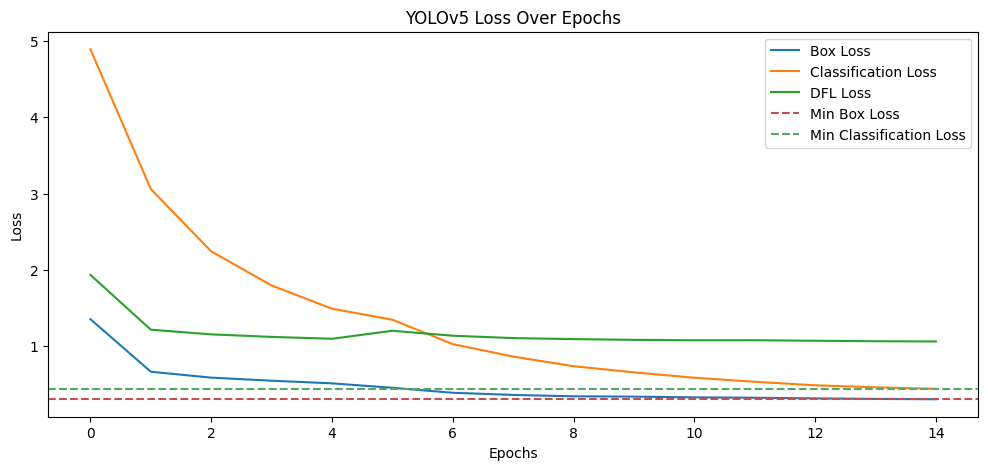

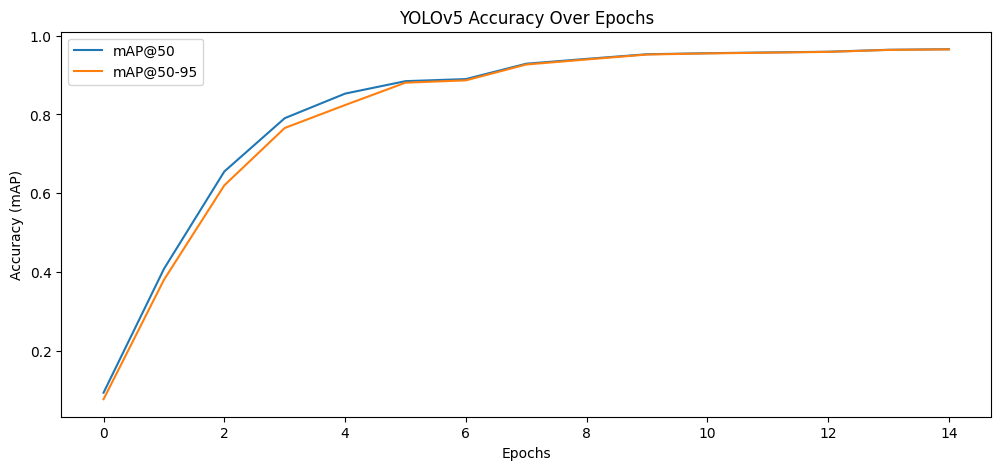


 Plotting Results for 2...



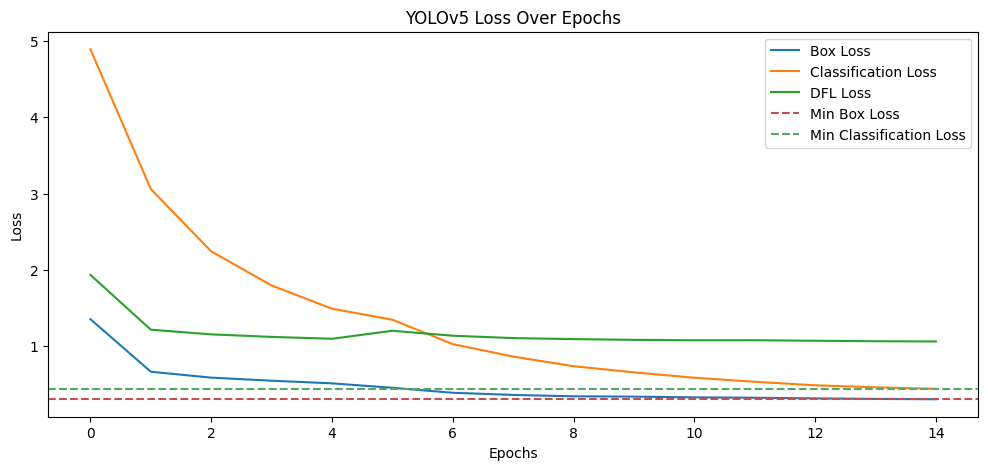

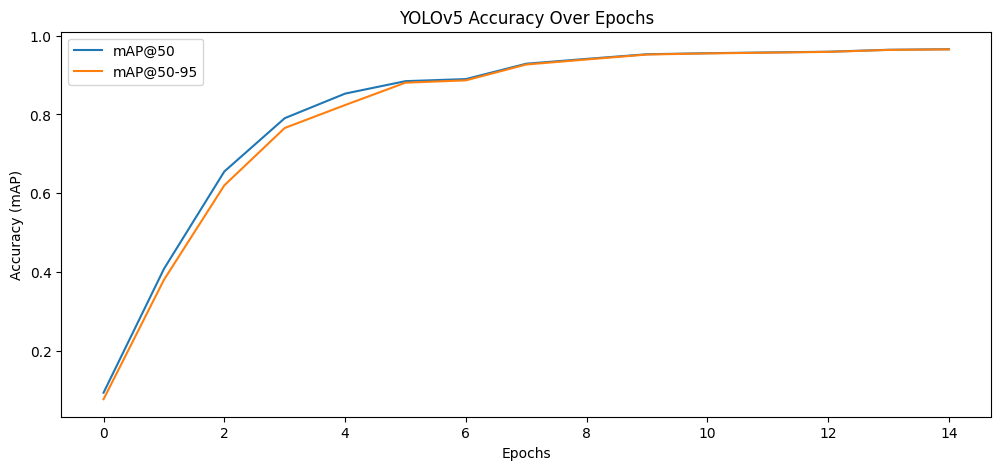

In [18]:
def plot_yolo_loss(run_dir):
    results_file = f"{run_dir}/results.csv"

    if not os.path.exists(results_file):
        print(f"Warning: {results_file} not found. Training might not have completed.")
        return

    df = pd.read_csv(results_file)
    epochs = df.index

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 1, 1)
    plt.plot(epochs, df["train/box_loss"], label="Box Loss")
    plt.plot(epochs, df["train/cls_loss"], label="Classification Loss")
    plt.plot(epochs, df["train/dfl_loss"], label="DFL Loss")

    plt.axhline(y=df["train/box_loss"].min(), color='r', linestyle='--', label="Min Box Loss")
    plt.axhline(y=df["train/cls_loss"].min(), color='g', linestyle='--', label="Min Classification Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("YOLOv5 Loss Over Epochs")
    plt.show()

def plot_yolo_accuracy(run_dir):
    results_file = f"{run_dir}/results.csv"

    if not os.path.exists(results_file):
        print(f"Warning: {results_file} not found. Training might not have completed.")
        return

    df = pd.read_csv(results_file)
    epochs = df.index

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 1, 1)
    plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP@50")
    plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP@50-95")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (mAP)")
    plt.legend()
    plt.title("YOLOv5 Accuracy Over Epochs")
    plt.show()


#Changed according to what we get in the testing above
run_dirs = ["runs/detect/train4", "runs/detect/train5"]

split = 1
for run_dir in run_dirs:
    print(f"\n Plotting Results for {split}...\n")
    plot_yolo_loss(run_dir)
    plot_yolo_accuracy(run_dir)
    split += 1
